In [44]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask, select_with_masks
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from json import load
import numpy as np
import logging
import bisect

# Created file and added transition function
# EW - April 2024

# Hard-coded rejection flags found in output files

# logger
logger = logging.getLogger(__name__)

def get_transition_probs(pes, interfaces, weights = None, tr=False):
    """
    Returns the local crossing probabilities for the PPTIS ensemble pe.
    This is only for the [i^+-] or [0^+-'] ensembles, and NOT for [0^-'].

    Parameters
    ----------
    pes : List of PathEnsemble objects
        The PathEnsemble object must be from an [i*] simulation.
    w : array-like, optional
        The weights of the paths. If None, the weights are calculated from
        the flags. The default is None.
    tr : bool, optional
        If True, infinite time-reversal reweighting is performed.
    Returns
    -------
    p : ndarray(2, 2)
        Matrix of all local crossing probabilities from one turn to another,
        in both directions.
    """
    masks = {}
    w_path = {}

    for i, pe in enumerate(pes):
        # Get the lmr masks, weights, ACCmask, and loadmask of the paths
        masks[i] = get_lmr_masks(pe)
        if weights is None:
            w, ncycle_true = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
            assert ncycle_true == pe.ncycle
        else:
            w = weights[i]
        accmask = get_flag_mask(pe, "ACC")
        loadmask = get_generation_mask(pe, "ld")
        msg = f"Ensemble {pe.name[-3:]} has {len(w)} paths.\n The total "+\
                    f"weight of the ensemble is {np.sum(w)}\nThe total amount of "+\
                    f"accepted paths is {np.sum(accmask)}\nThe total amount of "+\
                    f"load paths is {np.sum(loadmask)}"
        logger.debug(msg)

        w_path[i] = {}

        w_path[i]["ends"] = np.empty([len(interfaces),len(interfaces)])
        for j in range(len(interfaces)):
            for k in range(len(interfaces)):
                if j == k:
                        if i == 1 and j == 0:
                            w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [masks[i]["LML"], accmask, ~loadmask]))
                        else:
                            w_path[i]["ends"][j][k] = 0  
                elif j < k:
                    dir_mask = pe.dirs == 1
                    if j == 0:
                        start_cond = pe.lambmins <= interfaces[j]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[j], pe.lambmins >= interfaces[j-1])
                    if k == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[k]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[k], pe.lambmaxs <= interfaces[k+1])
                
                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                else:
                    dir_mask = pe.dirs == -1
                    if k == 0:
                        start_cond = pe.lambmins <= interfaces[k]
                    else: 
                        start_cond = np.logical_and(pe.lambmins <= interfaces[k], pe.lambmins >= interfaces[k-1])
                    if j == len(interfaces)-1:
                        end_cond = pe.lambmaxs >= interfaces[j]
                    else: 
                        end_cond = np.logical_and(pe.lambmaxs >= interfaces[j], pe.lambmaxs <= interfaces[j+1])

                    w_path[i]["ends"][j][k] = np.sum(select_with_masks(w, [start_cond, end_cond, dir_mask, accmask, ~loadmask]))
                    

        # if tr:  # TR reweighting. Note this is not block-friendly TODO
        #     w_path[i]['RMR'] *= 2
        #     w_path[i]['LML'] *= 2
        #     temp = w_path[i]['RML'] + w_path[i]['LMR']
        #     w_path[i]['RML'] = temp
        #     w_path[i]['LMR'] = temp

    p = np.empty([len(interfaces), len(interfaces)])
    for i in range(len(interfaces)):
        for k in range(len(interfaces)):
            if i == k:
                if i == 0:
                    p[i][k] = np.sum(w_path[i+1]["ends"][i][k]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else 0
                else:
                    p[i][k] = 0
            elif i < k:
                p_reachedj = np.empty(k-i+1)
                p_jtillend = np.empty(k-i+1)
                w_reachedj = np.empty(k-i+1)
                w_jtillend = np.empty(k-i+1)
                for j in range(i, k+1):
                    p_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][j:]) / np.sum(w_path[i+1]["ends"][i][i:]) if np.sum(w_path[i+1]["ends"][i][i:]) != 0 else 0
                    w_reachedj[j-i] = np.sum(w_path[i+1]["ends"][i][i:])
                    if j < len(interfaces)-1:
                        p_jtillend[j-i] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(w_path[j+1]["ends"][i][i:]) if np.sum(w_path[j+1]["ends"][i][i:]) != 0 else 0
                        w_jtillend[j-i] = np.sum(w_path[j+1]["ends"][i][i:])
                    else: 
                        p_jtillend[j-i] = 1
                        w_jtillend[j-i] = 1
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                print("weights: ", w_reachedj*w_jtillend)
                print("weighted P_i(k) =", np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0)
                print("vs normal avg: ", np.average(p_reachedj * p_jtillend))
                p[i][k] = np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0                
                # p[i][k] = np.average(p_reachedj * p_jtillend)
            elif i > k:
                p_reachedj = np.empty(i-k+1)
                p_jtillend = np.empty(i-k+1)
                w_reachedj = np.empty(i-k+1)
                w_jtillend = np.empty(i-k+1)
                for j in range(k, i+1):
                    if i < len(interfaces)-1:
                        p_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:j+1]) / np.sum(w_path[i+1]["ends"][i][:i+1]) if np.sum(w_path[i+1]["ends"][i][:i+1]) != 0 else 0
                        p_jtillend[j-k] = np.sum(w_path[j+1]["ends"][i][k]) / np.sum(w_path[j+1]["ends"][i][:i+1]) if np.sum(w_path[j+1]["ends"][i][:i+1]) != 0 else 0
                        w_reachedj[j-k] = np.sum(w_path[i+1]["ends"][i][:i+1])
                        w_jtillend[j-k] = np.sum(w_path[j+1]["ends"][i][:i+1])
                    else: 
                        p_reachedj[j-k] = 0
                        p_jtillend[j-k] = 0
                        w_reachedj[j-k] = 0
                        w_jtillend[j-k] = 0
                    
                print(f"i={interfaces[i]}, #j = {k-i}, k={interfaces[k]}")
                print("P_i(j reached) =", p_reachedj)
                print("P_j(k) =", p_jtillend)
                print("full P_i(k) =", p_reachedj*p_jtillend)
                print("weights: ", w_reachedj*w_jtillend)
                print("weighted P_i(k) =", np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0)
                print("vs normal avg: ", np.average(p_reachedj * p_jtillend))
                p[i][k] = np.average(p_reachedj * p_jtillend, weights=w_reachedj*w_jtillend) if np.sum(w_reachedj*w_jtillend) != 0 else 0
                # p[i][k] = np.average(p_reachedj * p_jtillend)

    msg = "Local crossing probabilities computed"
    print(msg)

    return p

In [46]:
%autoreload 2   # something with pip install -e .

UsageError: unrecognized arguments: # something with pip install -e .


# Reading

In [47]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/"
zero_minus_one = False
inputfile = indir + "logging.log"


import os
import glob
os.chdir(indir)
print(os.getcwd())

folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/004', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/005', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/006', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/007', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/008', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/009']


In [48]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    # pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar2/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ..., 37733, 37734, 37735]),
 'dirs': array([-1., -1.,  1., ...,  1.,  1., -1.]),
 'flags': array(['ACC', 'ACC', 'ACC', ..., 'ACC', 'ACC', 'ACC'], dtype='<U3'),
 'generation': array(['ld', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-1.0, -1.0, -1.0], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.999     , -0.99737022, -0.99562481, ..., -0.99198253,
       -0.99312391, -0.99674883]),
 'lambmins': array([-1.1       , -1.07814554, -1.41217253, ..., -1.64431627,
       -1.6515512 , -1.68193645]),
 'lengths': array([ 499,  119,  312, ..., 1860, 2008, 1847]),
 'lmrs': array(['RMR', 'RMR', 'RMR', ..., 'RMR', 'RMR', 'RMR'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34bb-4

# Analysis

In [49]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    if i != 1:
        print("Calculating path lengths.")
        set_tau_distrib(pathensembles[i])
        print("Done.")
    #else:
        #TODO problem with ...
    if i > 1:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")
    #else:
        # TODO problem with ....

0
Calculating path lengths.
Done.
1
2
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
3
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
4
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
5
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
6
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
7
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
8
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
9
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.


In [50]:
# Analyze the [i*] simulation.
# Analysis output is saved to the data dictionary.
data = {}

data["running"] = {}

# analysis using all data: ["full"]
data["full"] = get_transition_probs(pathensembles, interfaces)
pprint(data)


# for i, pe in enumerate(pathensembles):
#     print("doing pathensemble {}".format(i))
#     if i == 0:
#         data[i] = {}
#         continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    # pathtypes = ("LML", "LMR", "RML", "RMR")
    # pathtype_cycles = {}
    # for ptype in pathtypes:
    #     pathtype_cycles[ptype] = unwrap_by_weight(
    #             (pe.lmrs == ptype).astype(int), pe.weights)
    
    # # running average analysis: ["running"]
    # data[i] = {}
    # data[i]["running"] = {}
    # data[i]["running"]["plocal"] = {}
    # # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    # for (ptype, p_loc) in zip(pathtypes, 
    #                           running_avg_local_probs(pathtype_cycles, 
    #                                                   pe.weights, tr = False)):
    #     data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    # plocfull = get_local_probs(pe, tr=False)
    # data[i]["full"] = {}
    # for ptype in pathtypes:
    #     data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

i=-1.0, #j = 1, k=-0.75
P_i(j reached) = [1.        0.0039369]
P_j(k) = [0.0038305  0.98108974]
full P_i(k) = [0.0038305  0.00386246]
weights:  [1.41323365e+09 7.03740960e+08]
weighted P_i(k) = 0.0038411230656380537
vs normal avg:  0.0038464778290011707
i=-1.0, #j = 2, k=-0.5
P_i(j reached) = [1.00000000e+00 3.93690315e-03 1.06402788e-04]
P_j(k) = [7.98020908e-05 1.57051282e-02 8.51902967e-01]
full P_i(k) = [7.98020908e-05 6.18295687e-05 9.06448506e-05]
weights:  [1.41323365e+09 7.03740960e+08 7.08214527e+08]
weighted P_i(k) = 7.804327051610181e-05
vs normal avg:  7.742550335926143e-05
i=-1.0, #j = 3, k=-0.25
P_i(j reached) = [1.00000000e+00 3.93690315e-03 1.06402788e-04 2.66006969e-05]
P_j(k) = [0.         0.00192308 0.07314613 0.43881069]
full P_i(k) = [0.00000000e+00 7.57096759e-06 7.78295247e-06 1.16726703e-05]
weights:  [1.41323365e+09 7.03740960e+08 7.08214527e+08 6.65057763e+08]
weighted P_i(k) = 5.3299954239139916e-06
vs normal avg:  6.756647590020726e-06
i=-1.0, #j = 4, k=0.0


In [6]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'data' is not defined

This should be the same as the repptis_report.pdf value: 0.000507828487072553
which is the case!
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/tmp/ipykernel_16014/3779179883.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


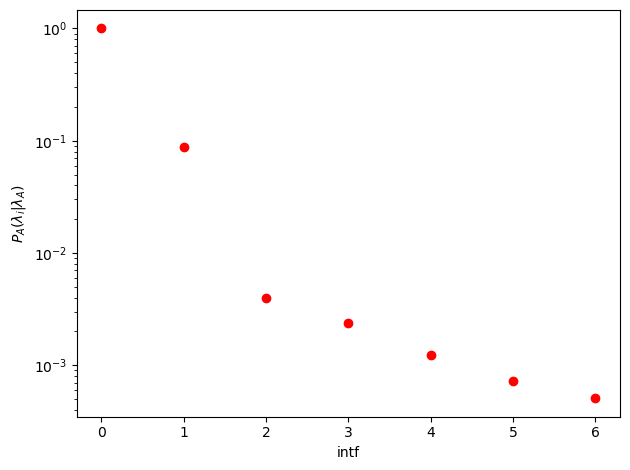

In [95]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")

# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)
ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

# Now work with MSM

In [51]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import vector_G

In [52]:
def create_labels_states(N):
    assert N>=3
    labels1 = ["0-     ","B      "]
    labels2 = ["0*-", "0*+"]
    if N>3:
        for i in range(1,N-1):
            labels2.append(str(i)  +"+")
        for i in range(1,N-1):
            labels2.append(str(i)  +"-")
    return labels1, labels2

def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [53]:
print(interfaces)
N = len(interfaces)
assert N >= 4
NS = 2*N
print("N", N)
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)
print(labels1, labels2)

[-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25]
N 10
NS 20
['0-     ', 'B      '] ['0*-', '0*+', '1+', '2+', '3+', '4+', '5+', '6+', '7+', '8+', '1-', '2-', '3-', '4-', '5-', '6-', '7-', '8-']


In [54]:
def construct_M_istar(P, NS, N):
    """Construct transition matrix M"""
    # N -- number of interfaces
    # NS -- dimension of MSM, 4*N-5 when N>=4
    # P -- ndarray of probabilities for paths between end turns
    
    # assert N>=4
    assert N==P.shape[0]
    assert N==P.shape[1]
    assert NS==2*N

    # construct transition matrix
    M = np.zeros((NS,NS))
    
    # states [0-] and [0*+-]
    M[0,2] = 1
    M[2,0] = P[0,0]
    M[2,N+1:] = P[0, 1:]
    M[1,0] = 1
    M[-1,0] = 1
    M[N+1:,2] = P[1:, 0]

    for i in range(1,N):
        #print("starting from state i",i)
        M[2+i, N+i:2*N] = P[i,i:]
        M[N+i, 3:2+i] = P[i, 1:i]

    for i in range(NS):
        M[i] = M[i]/np.sum(M[i])

    return M

In [55]:
print("p matrix: ", data["full"])
print("sum rows of p:")
for i in range(data["full"].shape[0]):
    print(np.sum(data["full"][i][:i]), np.sum(data["full"][i][i:]))
M = construct_M_istar(data["full"], NS, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

p matrix:  [[9.96063097e-01 3.84112307e-03 7.80432705e-05 5.32999542e-06
  4.09373378e-06 7.64977845e-07 1.40314884e-07 1.91417243e-08
             nan            nan]
 [1.00000000e+00 0.00000000e+00 8.05031447e-01 5.66037736e-02
  1.92307692e-02 4.09836066e-03 2.04498978e-03            nan
             nan            nan]
 [9.89369455e-01 1.06304985e-02 0.00000000e+00 3.92543860e-01
  2.77467453e-01 4.33148941e-02 2.10110256e-03            nan
             nan            nan]
 [           nan 1.38453765e-02 2.56540256e-02 0.00000000e+00
  5.07772021e-01 7.52445684e-02 2.32436387e-02            nan
             nan            nan]
 [           nan 1.02964723e-02 2.49982111e-02 4.36708861e-02
  0.00000000e+00 1.47822446e-01 2.01802497e-02 6.80833505e-03
             nan            nan]
 [           nan 6.74161535e-03 1.99199435e-02 3.69472974e-02
  2.75056518e-01 0.00000000e+00 2.99698992e-02 9.31717488e-03
  1.24405654e-02 9.48267051e-01]
 [           nan 3.95647873e-03 9.90099010e-04 

In [56]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (20, 20)
sum prob in rows [ 1.  1. nan nan nan nan nan  1.  1.  1.  1.  1.  1. nan nan nan nan nan
 nan  1.]
[[0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan]
 [       nan   

# Look at this Markov model

In [57]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

LinAlgError: Array must not contain infs or NaNs

In [31]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[2,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.05910622 0.         0.90263123 0.02618315 0.0120794  0.
 0.         0.         0.         0.        ]
1.0
[0.69666058 0.         0.05910622 0.         0.         0.
 0.0694864  0.06109125 0.0404579  0.07319765]
1.0
[0.11881647 0.         0.82484607 0.02863012 0.01421994 0.
 0.00455012 0.00341239 0.00203135 0.00349355]
1.0
[0.64011869 0.         0.12654877 0.00154759 0.00071397 0.
 0.06349834 0.05743965 0.03898192 0.07115107]
1.0000000000000002
[0.16882278 0.         0.75920579 0.02713165 0.01370117 0.
 0.00974198 0.0078368  0.00490695 0.00865287]
1.0
[0.59461614 0.         0.18597509 0.00360876 0.00172467 0.
 0.05844522 0.05313613 0.03623975 0.06625424]
1.0
[0.20979183 0.         0.70456069 0.02513918 0.01273737 0.
 0.01431674 0.01197455 0.0077108  0.01376884]
1.0
[0.55755642 0.         0.2355215  0.00556227 0.00271015 0.
 0.05423853 0.04929798 0.03362973 0.06148342]
1.0000000000000002
[0.24326147 0.         0.65957761 0.02332505 0.01182001 0.
 0.0181

# Pcross with MSM

In [58]:
def global_cross_prob_star(M, doprint=False):
    # probability to arrive in -1 before 0
    # given that you are at 0 now and that you are leaving 0
    # = crossing probability from 0 to -1

    NS = len(M)
    assert NS>2

    # take pieces of transition matrix
    Mp = M[2:-1,2:-1]
    a = np.identity(NS-3)-Mp    # 1-Mp
    # a1 = np.linalg.inv(a)       # (1-Mp)^(-1)  --> bad practice!

    # other pieces
    D = M[2:-1, np.array([0,-1])]
    E = M[np.array([0,-1]), 2:-1]
    M11 = M[np.array([0,-1]),np.array([0,-1])]

    # compute Z vector
    z1 = np.array([[0],[1]])
    # z2 = np.dot(a1,np.dot(D,z1))
    z2 = np.linalg.solve(a, np.dot(D,z1))

    # compute H vector
    y1 = np.dot(M11,z1) + np.dot(E,z2)
    y2 = np.dot(D,z1) + np.dot(Mp,z2)

    if doprint:
        print("Mp eigenvals")
        vals, vecs = np.linalg.eig(Mp)
        print(vals)
        print("1-Mp eigenvals")
        vals, vecs = np.linalg.eig(a)
        print(vals)
        #print(np.dot(a,a1)  # identity matrix indeed
        print("other pieces M")
        print(D)
        print(E)
        print(M11)
        print("vector z1,z2")
        print(z1)
        print(z2)
        print("vector y1,y2")
        print(y1)
        print(y2)
        print("check", np.sum((y2-z2)**2))  # 0, so z2 and y2 indeed the same
    return z1, z2, y1, y2

In [59]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob_star(M, True)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Mp eigenvals


LinAlgError: Array must not contain infs or NaNs

# Collecting times

In [105]:
#TODO I need data too?

In [106]:
def collect_tau(pathensembles, data):
    # pathensembles -- list of pathensemble instances
    
    print("Collect tau")
    
    # average path lengths
    taumm = np.zeros(len(pathensembles))
    taump = np.zeros(len(pathensembles))
    taupm = np.zeros(len(pathensembles))
    taupp = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        print("ensemble", i, pathensembles[i].name)
        taumm[i] = pathensembles[i].tauavg['LML']-2
        taump[i] = pathensembles[i].tauavg['LMR']-2
        taupm[i] = pathensembles[i].tauavg['RML']-2
        taupp[i] = pathensembles[i].tauavg['RMR']-2

    # for [0-] (i=0)
    print("ensemble", 0, pathensembles[0].name)
    if pe.has_zero_minus_one:
        # TODO pieces missing
        taumm[0] = pathensembles[0].tauavg['LML']-2
        taump[0] = pathensembles[0].tauavg['LMR']-2
        taupm[0] = pathensembles[0].tauavg['RML']-2
        taupp[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1)
    print("ensemble", 1, pathensembles[1].name)
    taumm[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    taump[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    taupm[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    #taupp[1] = data[1]["pathlengths"]["RMR"]["mean"] - 2

    return taumm, taump, taupm, taupp

# this is the same:
# 1) after:
#   data[2]["pathlengths"] = pathlength_distr(upe)  # use correct upe!
#   This gives the whole distrib, mean, std, etc
#   print(data[2]["pathlengths"]["RMR"]["mean"])
# 2) after:
#   set_tau_distrib(pathensembles[2])
#   print(pathensembles[2].tauavg['RMR'])

# TODO for [0-]
# likely not okay yet, what about L*L etc??????
# There are paths missing TODO!!!!!!!! when lambda-1

In [107]:
# TODO fix +-1 issues!!!!!!
# TODO tau1 is not fool proof if you have too many phase points!!

def collect_tau1(pathensembles, data):
    # average path lengths, but only the part before the 1st crossing
    #---------------------------
    print("Collect tau1")
    taumm1 = np.zeros(len(pathensembles))
    taump1 = np.zeros(len(pathensembles))
    taupm1 = np.zeros(len(pathensembles))
    taupp1 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm1[i] = pathensembles[i].tau1avg['LML'] - 1
        taump1[i] = pathensembles[i].tau1avg['LMR'] - 1
        taupm1[i] = pathensembles[i].tau1avg['RML'] - 1
        taupp1[i] = pathensembles[i].tau1avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML
    taupm1[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    
    return taumm1, taump1, taupm1, taupp1

def collect_tau2(pathensembles, data):
    # average path lengths, but only the part after the last crossing
    #---------------------------
    print("Collect tau2")
    taumm2 = np.zeros(len(pathensembles))
    taump2 = np.zeros(len(pathensembles))
    taupm2 = np.zeros(len(pathensembles))
    taupp2 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm2[i] = pathensembles[i].tau2avg['LML'] - 1
        taump2[i] = pathensembles[i].tau2avg['LMR'] - 1
        taupm2[i] = pathensembles[i].tau2avg['RML'] - 1
        taupp2[i] = pathensembles[i].tau2avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR
    taump2[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    # for [0+-] (i=1) RML -> just 0
    
    return taumm2, taump2, taupm2, taupp2

def collect_taum(pathensembles, data):
    # average path lengths, but only the part between first/last crossing
    #---------------------------
    print("Collect taum")
    taumm_m = np.zeros(len(pathensembles))
    taump_m = np.zeros(len(pathensembles))
    taupm_m = np.zeros(len(pathensembles))
    taupp_m = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        #print("ensemble", i, pathensembles[i].name)
        taumm_m[i] = pathensembles[i].tauavg['LML'] \
                   - pathensembles[i].tau1avg['LML'] \
                   - pathensembles[i].tau2avg['LML']
        taump_m[i] = pathensembles[i].tauavg['LMR'] \
                   - pathensembles[i].tau1avg['LMR'] \
                   - pathensembles[i].tau2avg['LMR']
        taupm_m[i] = pathensembles[i].tauavg['RML'] \
                   - pathensembles[i].tau1avg['RML'] \
                   - pathensembles[i].tau2avg['RML']
        taupp_m[i] = pathensembles[i].tauavg['RMR'] \
                   - pathensembles[i].tau1avg['RMR'] \
                   - pathensembles[i].tau2avg['RMR']

    # for [0-] (i=0)
    if pe.has_zero_minus_one:
        # TODO there are more paths!!!
        taumm_m[0] = pathensembles[0].tauavg['LML']-2
        taump_m[0] = pathensembles[0].tauavg['LMR']-2
        taupm_m[0] = pathensembles[0].tauavg['RML']-2
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1) LML
    taumm_m[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML -> just 0

    return taumm_m, taump_m, taupm_m, taupp_m


In [108]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name[-3:]}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [109]:
taumm, taump, taupm, taupp = collect_tau(pathensembles, data)
taumm1, taump1, taupm1, taupp1 = collect_tau1(pathensembles, data)
taumm2, taump2, taupm2, taupp2 = collect_tau2(pathensembles, data)
taumm_m, taump_m, taupm_m, taupp_m = collect_taum(pathensembles, data)

Collect tau
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/004
ensemble 5 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/005
ensemble 6 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/006
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3/001
Collect tau1
Collect tau2
Collect taum


In [110]:
print("tau")
print_all_tau(pathensembles, taumm, taump, taupm, taupp)
print("\ntau1")
print_all_tau(pathensembles, taumm1, taump1, taupm1, taupp1)
print("\ntau_m")
print_all_tau(pathensembles, taumm_m, taump_m, taupm_m, taupp_m)
print("\ntau2")
print_all_tau(pathensembles, taumm2, taump2, taupm2, taupp2)

tau
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0         122.6
1 001           41.0         132.9         129.9           0.0
2 002          558.3         690.8         697.8         849.9
3 003          857.0         578.4         574.5         468.0
4 004          220.2         169.6         170.6         196.5
5 005          174.1         139.2         137.9         163.1
6 006          144.0         114.5         112.1         141.0

tau1
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0           0.0
1 001            0.0           0.0         129.9           0.0
2 002          135.1         133.9         330.5         305.8
3 003          338.2         321.8          54.6          55.0
4 004           54.1          53.4          55.7          54.6
5 005           55.7          54.7          41.4          42.9
6 006           43.1          41.4          3

In [111]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=4
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [112]:
tau  = construct_tau_vector(N, NS, taumm, taump, taupm, taupp)
tau1 = construct_tau_vector(N, NS, taumm1, taump1, taupm1, taupp1)
taum = construct_tau_vector(N, NS, taumm_m, taump_m, taupm_m, taupp_m)
tau2 = construct_tau_vector(N, NS, taumm2, taump2, taupm2, taupp2)
tau_m = tau-tau1-tau2  # yes, this is the same thing

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[122.59844936  40.95532539 132.88517875 129.89168347 558.25282787
 690.82414272 697.81777379 849.92352941 856.95789217 578.36564823
 574.48554716 467.97282638 220.24115756 169.63737921 170.64555582
 196.52998436 174.06787707 139.15997954 137.86758565 163.07190705
 143.97923281 114.52065576   0.        ]


tau1
[  0.           0.           0.         129.89168347 135.14434756
 133.93721038 330.54241472 305.82352941 338.18297432 321.83558936
  54.5684215   55.03888919  54.0726072   53.40919161  55.68400095
  54.62489136  55.68876489  54.74841044  41.44391884  42.92442956
  43.0765107   41.36328045   0.        ]
taum
[122.59844936  40.95532539   0.           0.         288.43468998
 226.48540315 229.43087971 234.05882353 185.48679567 201.91053242
 197.16673071 358.40817378 111.97281322  61.35465473  61.10836691
  86.63045368  63.11268427  42.23540159  41.92135703  76.86215198
  57.6097434   38.96362302   0.        ]
tau2
[  0.           0.         132.88517875   0.         134.6737903

# Compute tau for [0+]

In [113]:
g1, g2, h1, h2 = vector_G(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 40.95532539064838
state 0+- LMR 634.4580991219331
state 0+- RML 0.0
state 1+- LML 423.1084803092534
state 1+- LMR 2156.9980787004515
state 1+- RML 367.2753590664273
state 1+- RMR 2144.211146355688
state 2+- LML 951.3505544465012
state 2+- LMR 2058.2664283562713
state 2+- RML 952.4927622497322
state 2+- RMR 2214.670306676231
state 3+- LML 1890.558398157917
state 3+- LMR 1584.2888227866179
state 3+- RML 1839.3514026696503
state 3+- RMR 1609.9657281784657
state 4+- LML 1908.5776623010288
state 4+- LMR 888.2220093777526
state 4+- RML 1886.622216918643
state 4+- RMR 923.9579177737457
state 5+- LML 1736.3219588347583
state 5+- LMR 73.15737531095795
H
state 0-      93.1689994269615
state B       0.0
state 0+- LML 0.0
state 0+- LMR 634.4580991219332
state 0+- RML 0.0
state 1+- LML 134.6737903314371
state 1+- LMR 1930.5126755493857
state 1+- RML 137.84447935368044
state 1+- RMR 1910.1523228262758
state 2+- LML 765.8637587789826
state 2+- LMR 1

In [114]:
print(h1[0])

[93.16899943]


# Flux

In [115]:
flux = 1/(tau[0]+h1[0])
# dt = 0.0002
# dt = 0.00002
dt = 0.01
flux
print(flux/dt, "1/time")

[0.46346194] 1/time
